In [50]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

# def which_tID(tvec,t):
#     tID = np.argmin(np.abs(tvec-t))
#     return tID

# def growth_rates(filename_prefix):
#     fname = filename_prefix+'growth.dat'
#     dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
#     n = np.size(dat)

#     nstats=3
#     dat = np.reshape(dat,[n/nstats,nstats])
#     time = dat[:,0]
#     dtheta = dat[:,1]
#     rate = dat[:,2]
#     return time,dtheta,rate    

# def get_centerline(y,Rij): # either R11 or R22 as a vector
#     idx = np.argmax(Rij)
#     return y[idx],idx
    
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*Rij*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')


Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024.0x1448.0x512.0
	L = 80.0x80.0x40.0
['shearlayer_Rij_0001.dat', 'shearlayer_Rij_0002.dat', 'shearlayer_Rij_0003.dat', 'shearlayer_Rij_0004.dat', 'shearlayer_Rij_0005.dat', 'shearlayer_Rij_0006.dat', 'shearlayer_Rij_0007.dat', 'shearlayer_Rij_0008.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
	[0.131798886789,0.00449147991223],
	[0.0782709372446,0.00181021472977],
	[0.0659771819269,0.00227210258691],


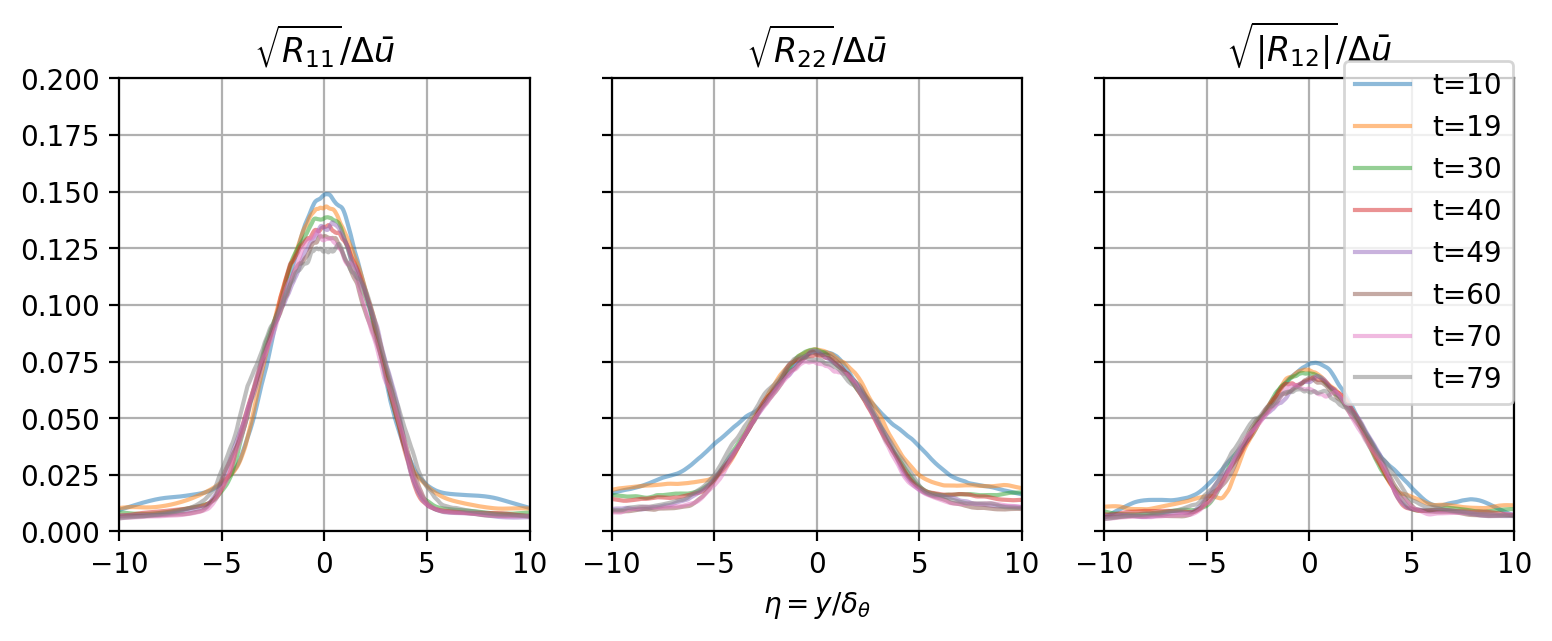

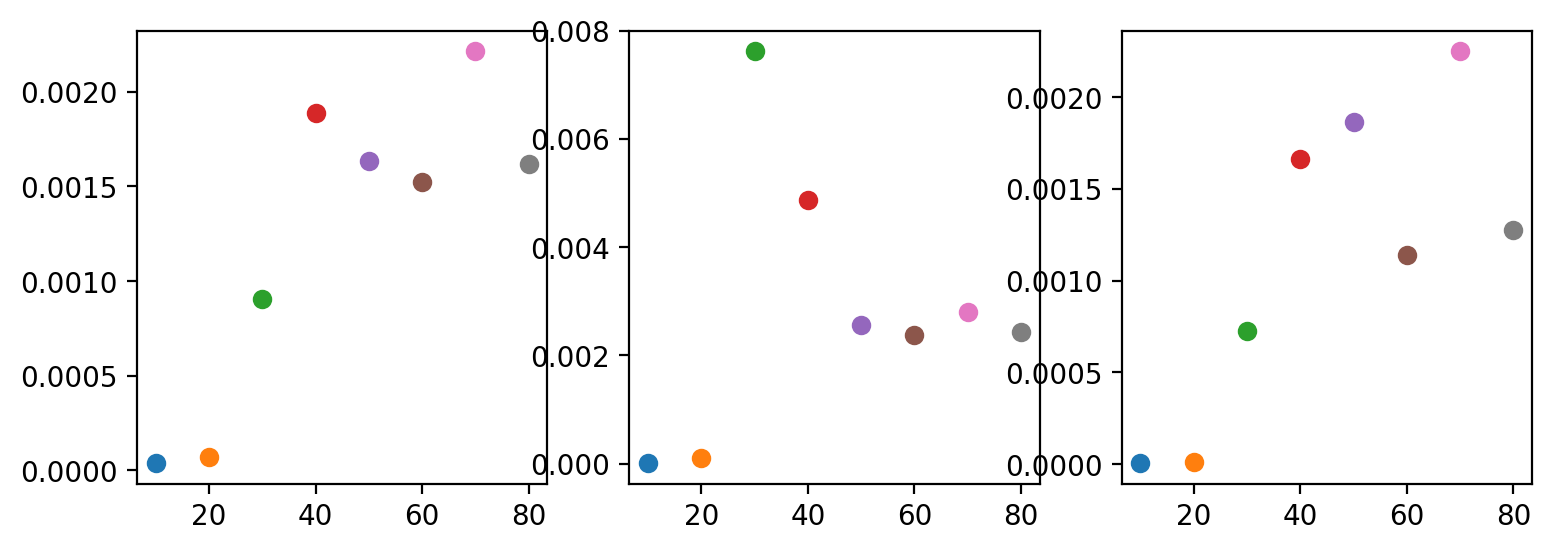

In [51]:
# Nicer Rij profiles

fig,ax = plt.subplots(1,3,figsize=(9,3), dpi=200)
fig2,ax2 = plt.subplots(1,3,figsize=(9,3), dpi=200)

flist_plot = flist[::]
Rij_center = np.zeros([3,len(flist_plot)])
counter = 0

for fname in flist_plot:
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)
    
    # Get dtheta
    idx = np.argmin(abs(tlist-time))
    yplot = y/dlist[idx]
    
    # Get Rij
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    dat = np.flipud(dat)
    R11 = dat[:,0]
    R12 = dat[:,1]
    R22 = dat[:,3]  
    
    R11 = np.sqrt(R11)/inp.du
    R22 = np.sqrt(R22)/inp.du
    R12 = np.sqrt(abs(R12))/inp.du
    ax[0].plot(yplot,R11,alpha=0.5,label='t=%d'%time)
    ax[1].plot(yplot,R22,alpha=0.5,label='t=%d'%time)
    ax[2].plot(yplot,R12,alpha=0.5,label='t=%d'%time)
    
    # Get centerline stats
    ic,yc = get_centerline(y,R22)
    Rij_center[0,counter] = R11[ic]
    Rij_center[1,counter] = R22[ic]
    Rij_center[2,counter] = R12[ic]
    counter += 1

    ax2[0].plot(time,R11[idx],'o')
    ax2[1].plot(time,R22[idx],'o')
    ax2[2].plot(time,R12[idx],'o')
    
ax[0].set_title(r'$\sqrt{R_{11}}/\Delta \bar{u}$')
ax[1].set_title(r'$\sqrt{R_{22}}/\Delta \bar{u}$')
ax[2].set_title(r'$\sqrt{|R_{12}|}/\Delta \bar{u}$')

ax[1].set_xlabel(r'$\eta = y/\delta_\theta$')
ax[1].set_yticklabels([''])
ax[2].set_yticklabels([''])
for a in ax:
    a.set_xlim([-10,10])
    a.set_ylim([0,0.2])
    a.grid(True)

plt.subplots_adjust(hspace = 0.5)

ax[2].legend(bbox_to_anchor=(0.55,0.25))
# plt.savefig(directory+'/img/Rij.png',dpi=200)

j = 2
print(directory)
for i in range(3):
    print("\t[{},{}],".format(np.mean(Rij_center[i,j:]),np.std(Rij_center[i,j:])))
    
fig.savefig(directory+'/img/Rij.png',dpi=200, bbox_inches='tight')

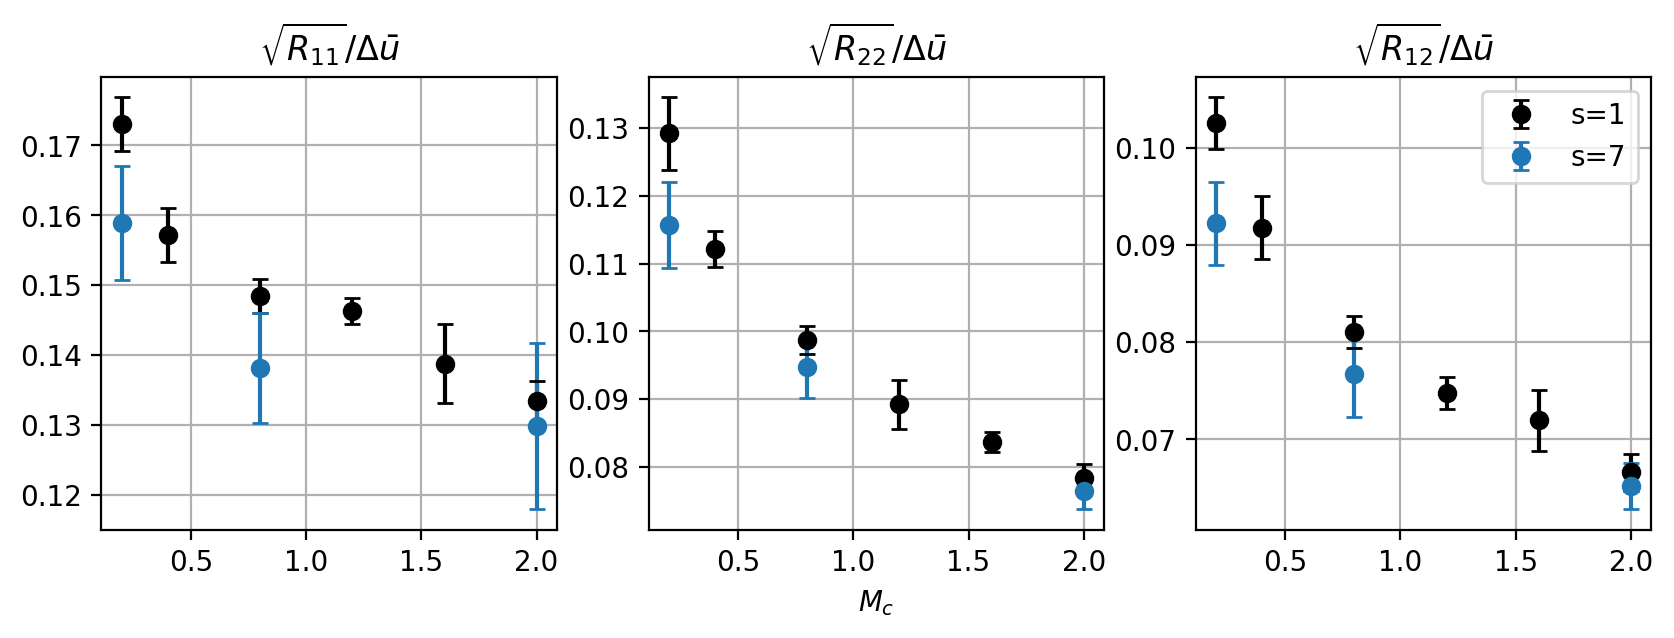

In [32]:
DPI=200
# s=1
Rij = {}
Rij[0] = {
    0.2: [0.173086399346,0.00381388627119],
    0.4: [0.157232222529,0.00384746997228],
    0.8: [0.148451092848,0.00242288995129],
    1.2: [0.146326170175,0.00190222660729],
    1.6: [0.13878924786,0.00563756814963],
    2.0: [0.133415766957,0.00291929123059],
}
Rij[1] = {
    0.2: [0.129178679426,0.00533973685134],
    0.4: [0.112183428384,0.00264529379514],
    0.8: [0.0987368451475,0.00199911841394],
    1.2: [0.0892276306873,0.00360714524615],
    1.6: [0.0837138460896,0.00141864607926],
    2.0: [0.0784510307262,0.00193330051176],
}
Rij[2] = {
    0.2: [0.102559631411,0.0026427842056],
    0.4: [0.0917861799773,0.0032219296441], 
    0.8: [0.0810654397338,0.00164376558218],
    1.2: [0.0747749252058,0.00164801652619],
    1.6: [0.0719482364037,0.003137065075],
    2.0: [0.0666369761625,0.00189287337095],
}

# s=1/7
Rij_rr_7 = {}
Rij_rr_7[0] = {
    0.2: [0.152391688239,0.00368177564802],
    0.8: [0.138154069068,0.00226542082592],
    2.0: [0.130055115342,0.00915918590473],
}
Rij_rr_7[1] = {
    0.2: [0.110326579413,0.00487057986084],
    0.8: [0.0935345692059,0.00346059609841],
    2.0: [0.0791147856457,0.00152742632348],
}
Rij_rr_7[2] = {
    0.2: [0.0898297917363,0.00145152970168],
    0.8: [0.0763047930365,0.00242587398432],
    2.0: [0.0658113811114,0.0021228247779],
}
    
# s=7
Rij_rr7 = {}
Rij_rr7[0] = {
    0.2: [0.165522024988,0.0072381018265],
    0.8: [0.138258129235,0.00757737349312],
    2.0: [0.129774750095,0.00760306887704],
}
Rij_rr7[1] = {
    0.2: [0.120985029914,0.00408902925927],
    0.8: [0.0958255139904,0.00291741041573],
    2.0: [0.0737061603818,0.002099294066],
}
Rij_rr7[2] = {
    0.2: [0.0946673285415,0.00403027220938],
    0.8: [0.0772340409351,0.00369422810456],
    2.0: [0.0645934955048,0.00104034185474],
}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = (e1**2+e2**2)**0.5
        new[key] = [(v1+v2)/2., err]
    return new

rr = {}
for i in range(3): rr[i] = merge_dicts(Rij_rr7[i],Rij_rr_7[i])

    
# Plot for all
fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=200)
offset=0.01

for i in range(3):
    ax[i].errorbar(Rij[i].keys(),[x[0] for x in Rij[i].values()],
        yerr=[x[1] for x in Rij[i].values()],fmt='ko',capsize=3,label='s=1')
    ax[i].errorbar(rr[i].keys(),[x[0] for x in rr[i].values()],
        yerr=[x[1] for x in rr[i].values()],fmt='o',capsize=3,label='s=7')
#     ax[i].errorbar([k-offset for k in Rij_rr_7[i].keys()],[x[0] for x in Rij_rr_7[i].values()],
#         yerr=[x[1] for x in Rij_rr_7[i].values()],fmt='o',capsize=3,label='PadeOps: s=1/7')
#     ax[i].errorbar([k+offset for k in Rij_rr7[i].keys()],[x[0] for x in Rij_rr7[i].values()],
#         yerr=[x[1] for x in Rij_rr7[i].values()],fmt='o',capsize=3,label='PadeOps: s=7')
    
ax[0].set_title(r'$\sqrt{R_{11}}/\Delta \bar{u}$')
ax[1].set_title(r'$\sqrt{R_{22}}/\Delta \bar{u}$')
ax[2].set_title(r'$\sqrt{R_{12}}/\Delta \bar{u}$')
ax[1].set_xlabel('$M_c$')
ax[2].legend()

for a in ax:
    a.grid(True)

plt.savefig('/home/kmatsuno/ShearLayer_img/Rij_peaks.png',dpi=DPI, bbox_inches='tight')
 

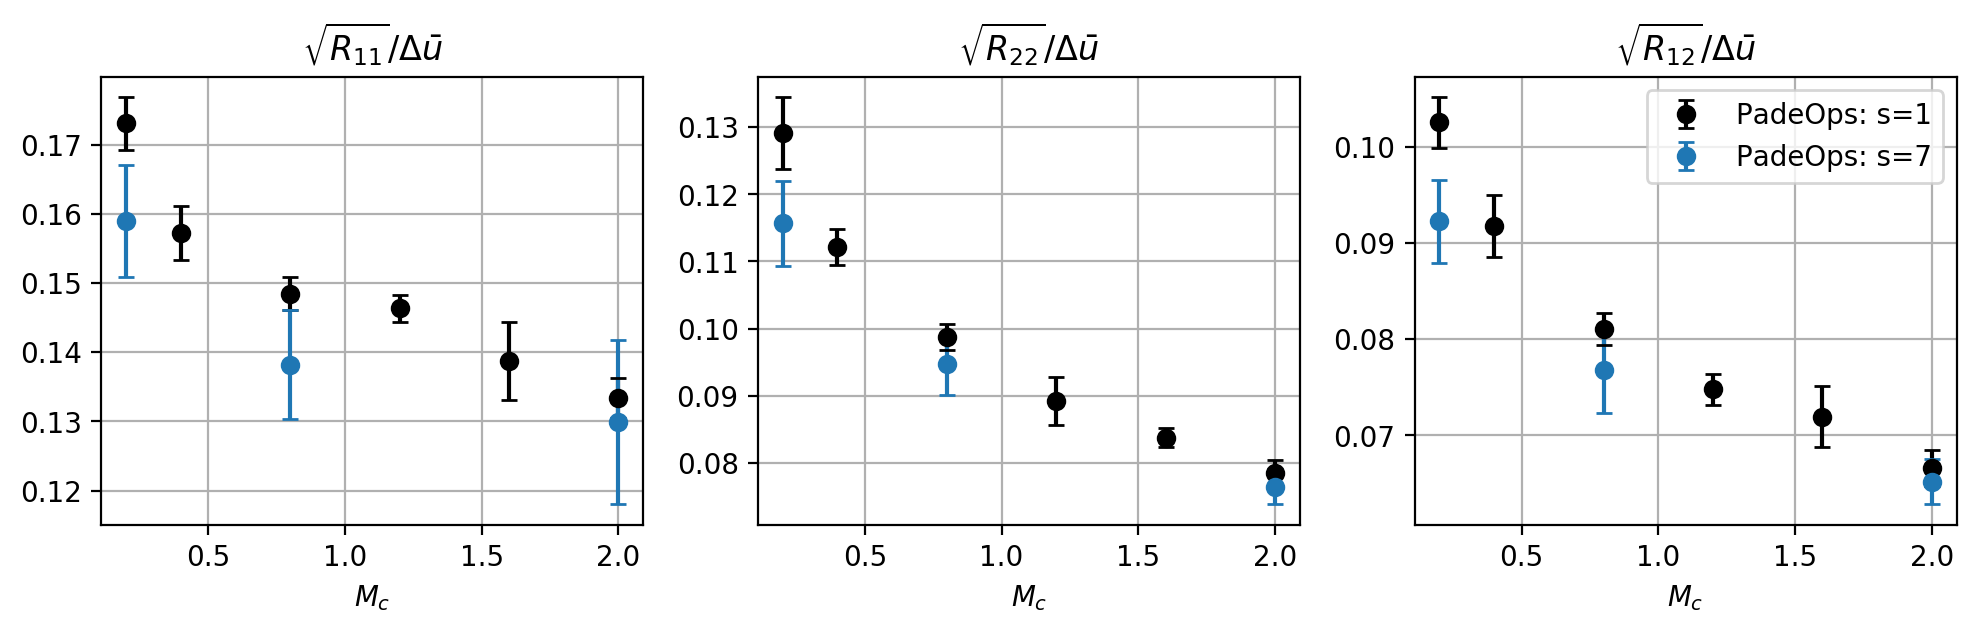

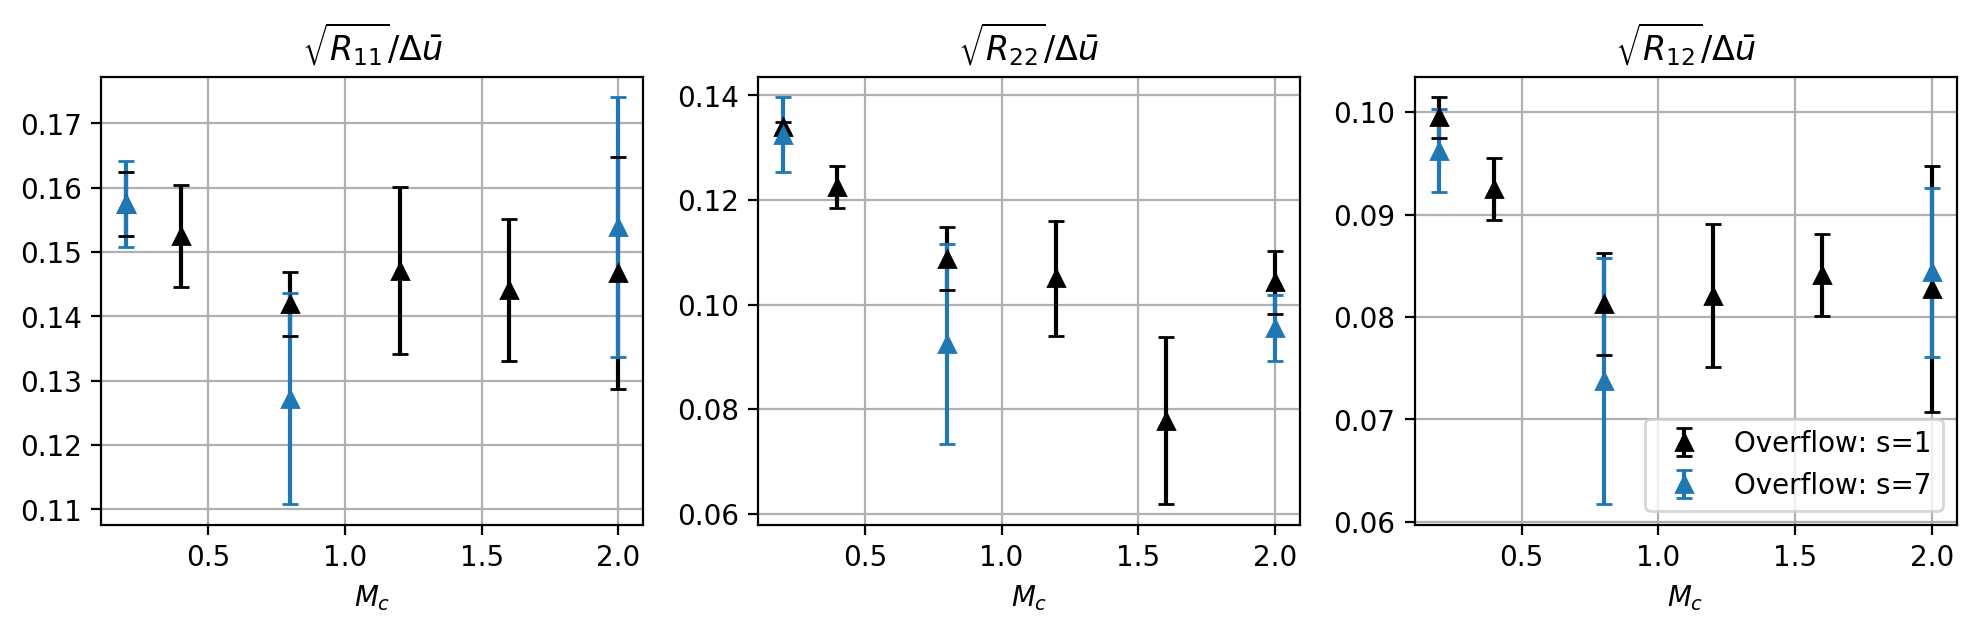

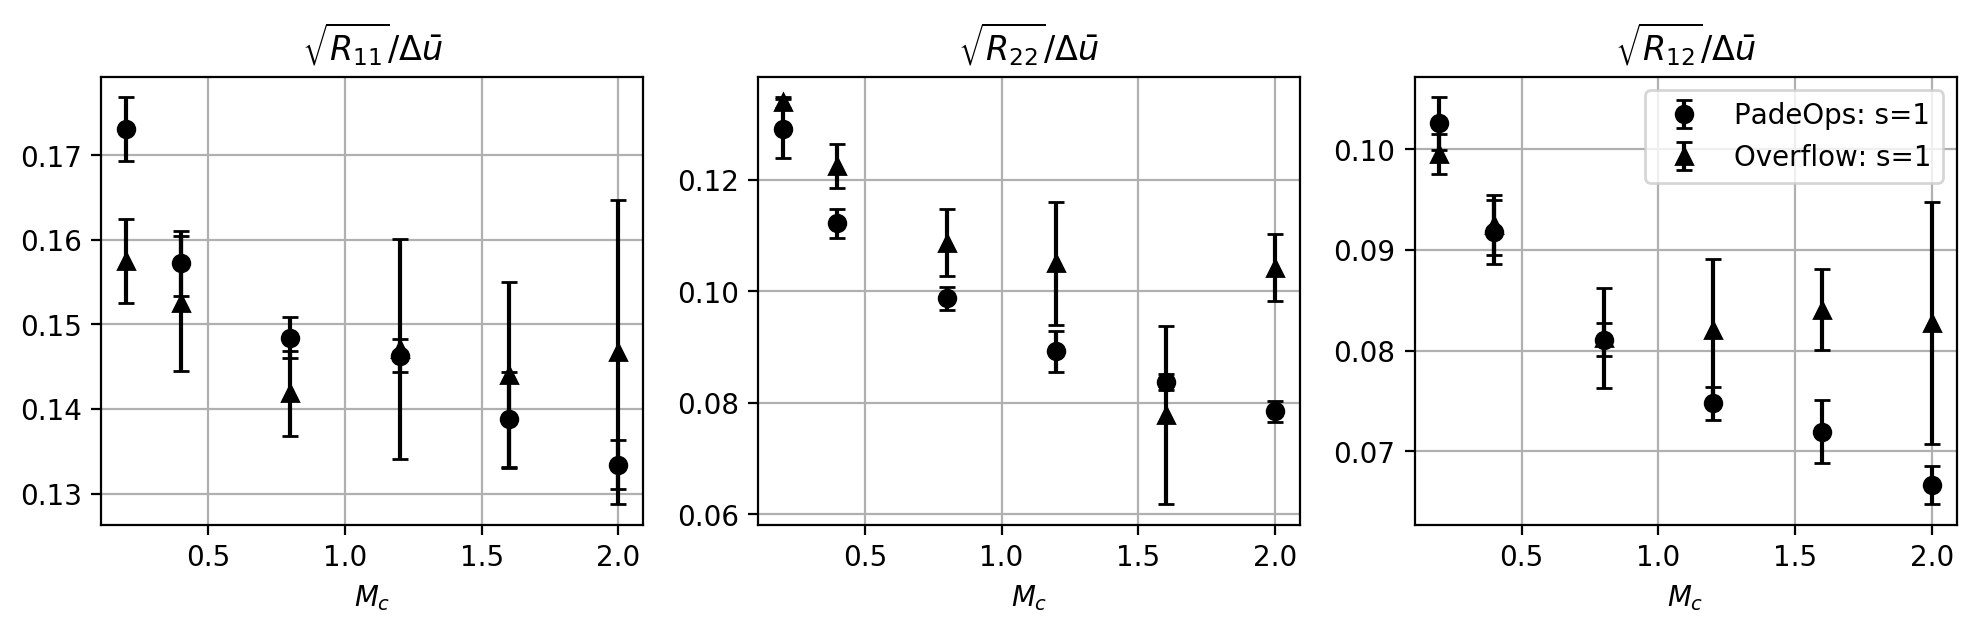

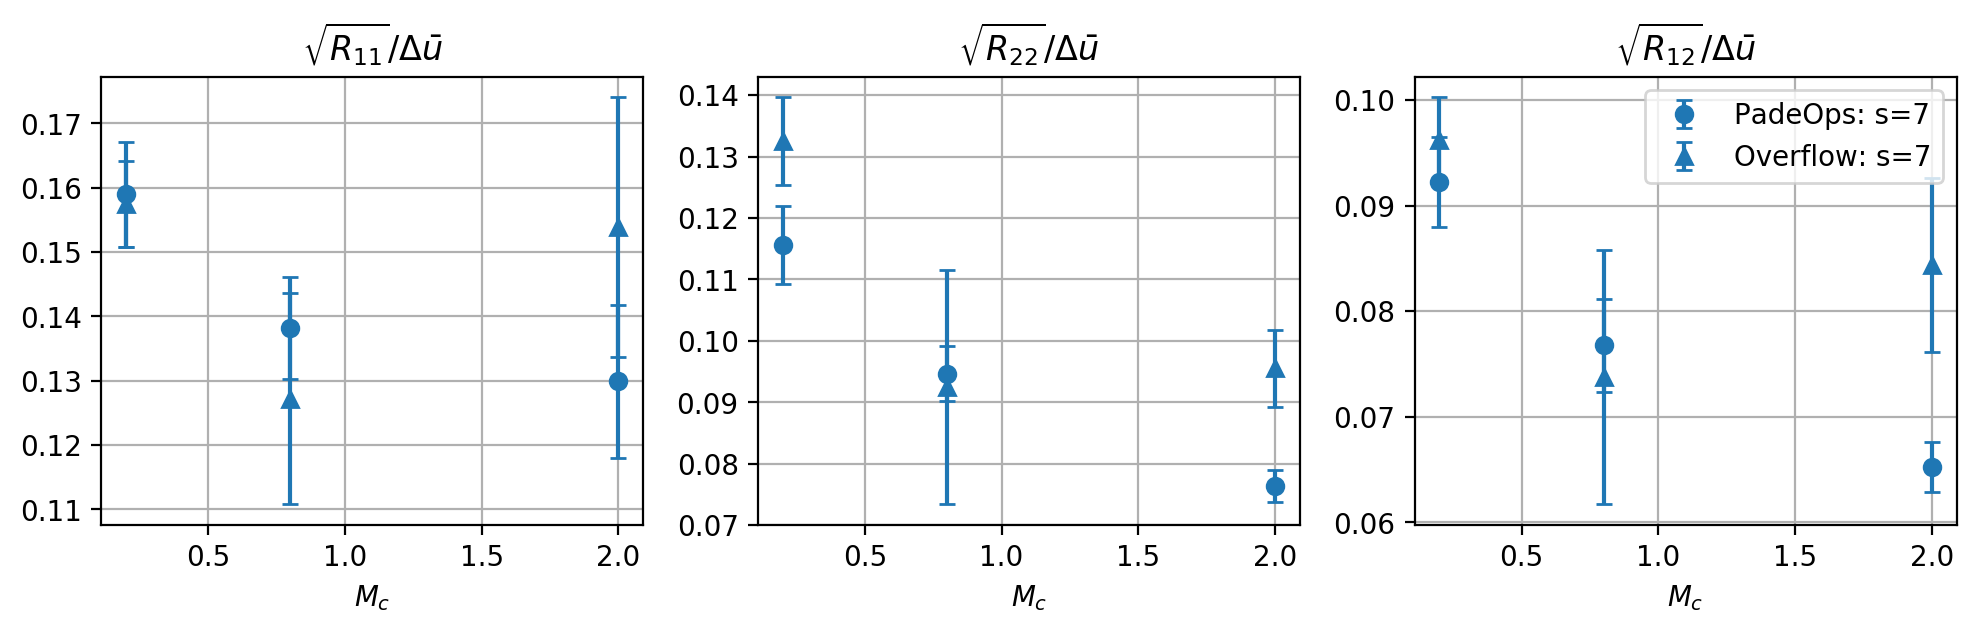

In [33]:
# Compare to Overflow

# s=1
Rij_ovf = {}
Rij_ovf[0] = {
    0.2: [0.063,0.005],
    0.4: [0.122,0.008],
    0.8: [0.227,0.005],
    1.2: [0.353,0.013],
    1.6: [0.461,0.011],
    2.0: [0.587,0.018],
}
Rij_ovf[1] = {
    0.2: [0.05355,0.001],
    0.4: [0.098,0.004],
    0.8: [0.174,0.006],
    1.2: [0.252,0.011],
    1.6: [0.249,0.016],
    2.0: [0.417,0.006],
}
Rij_ovf[2] = {
    0.2: [0.0398,0.002],
    0.4: [0.074,0.003],
    0.8: [0.130,0.005],
    1.2: [0.197,0.007],
    1.6: [0.269,0.004],
    2.0: [0.331,0.012],
}    

# s=1/7
Rij_rr_7_ovf = {}
Rij_rr_7_ovf[0] = {
    0.2: [0.06,0.003],
    0.8: [0.201,0.010],
    2.0: [0.661,0.019],
}
Rij_rr_7_ovf[1] = {
    0.2: [0.051,0.004],
    0.8: [0.147,0.013],
    2.0: [0.406,0.006],
}
Rij_rr_7_ovf[2] = {
    0.2: [0.037,0.0025],
    0.8: [0.117,0.008],
    2.0: [0.35,0.008],
}
    
# s=7
Rij_rr7_ovf = {}
Rij_rr7_ovf[0] = {
    0.2: [0.066,0.006],
    0.8: [0.206,0.013],
    2.0: [0.570,0.007],
}
Rij_rr7_ovf[1] = {
    0.2: [0.055,0.006],
    0.8: [0.149,0.014],
    2.0: [0.358,0.002],
}
Rij_rr7_ovf[2] = {
    0.2: [0.040,0.0032],
    0.8: [0.119,0.009],
    2.0: [0.325,0.002],
}
    
for i in range(3):
    for Mc, value in Rij_ovf[i].iteritems():
        du = 2*Mc
        value[0] /= du
        Rij_ovf[i][Mc] = value
    for Mc, value in Rij_rr_7_ovf[i].iteritems():
        du = 2*Mc
        value[0] /= du
        Rij_rr_7_ovf[i][Mc] = value   
    for Mc, value in Rij_rr7_ovf[i].iteritems():
        du = 2*Mc
        value[0] /= du
        Rij_rr7_ovf[i][Mc] = value
        
rr_ovf = {}
for i in range(3): rr_ovf[i] = merge_dicts(Rij_rr7_ovf[i],Rij_rr_7_ovf[i])

offset = 0.02

def make_nice(a):
    a.grid(True)
    a.set_xlabel(r'$M_c$')
    #a.set_ylim([0.05,0.18])
    plt.tight_layout()
def make_nice2():
    ax[2].legend()
    ax[0].set_title(r'$\sqrt{R_{11}}/\Delta \bar{u}$')
    ax[1].set_title(r'$\sqrt{R_{22}}/\Delta \bar{u}$')
    ax[2].set_title(r'$\sqrt{R_{12}}/\Delta \bar{u}$')
    ax[1].set_xlabel('$M_c$')

# Compare 
prefix = '/home/kmatsuno/Ovf_compare/Rij_peaks_'
DPI=200

fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=DPI)
for i in range(3):
    ax[i].errorbar(Rij[i].keys(),[x[0] for x in Rij[i].values()],
         yerr=[x[1] for x in Rij[i].values()],fmt='ko',capsize=3,label='PadeOps: s=1')
    ax[i].errorbar(rr[i].keys(),[x[0] for x in rr[i].values()],
        yerr=[x[1] for x in rr[i].values()],fmt='o',capsize=3,label='PadeOps: s=7')
    make_nice(ax[i])
make_nice2()
plt.savefig(prefix+'padeops.png',dpi=DPI, bbox_inches='tight')
    
fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=DPI)
for i in range(3):
    ax[i].errorbar(Rij_ovf[i].keys(),[x[0] for x in Rij_ovf[i].values()],
         yerr=[x[1] for x in Rij_ovf[i].values()],fmt='k^',capsize=3,label='Overflow: s=1')
    ax[i].errorbar(rr_ovf[i].keys(),[x[0] for x in rr_ovf[i].values()],
        yerr=[x[1] for x in rr_ovf[i].values()],fmt='^',capsize=3,label='Overflow: s=7')
    make_nice(ax[i])
make_nice2()
plt.savefig(prefix+'ovf.png',dpi=DPI, bbox_inches='tight')

fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=DPI)
for i in range(3):
    ax[i].errorbar(Rij[i].keys(),[x[0] for x in Rij[i].values()],
         yerr=[x[1] for x in Rij[i].values()],fmt='ko',capsize=3,label='PadeOps: s=1')
    ax[i].errorbar(Rij_ovf[i].keys(),[x[0] for x in Rij_ovf[i].values()],
        yerr=[x[1] for x in Rij_ovf[i].values()],fmt='k^',capsize=3,label='Overflow: s=1')
    make_nice(ax[i])
make_nice2()
plt.savefig(prefix+'rr1.png',dpi=DPI, bbox_inches='tight')

fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=DPI)
for i in range(3):
    ax[i].errorbar(rr[i].keys(),[x[0] for x in rr[i].values()],
         yerr=[x[1] for x in rr[i].values()],fmt='o',color='C0',capsize=3,label='PadeOps: s=7')
    ax[i].errorbar(rr_ovf[i].keys(),[x[0] for x in rr_ovf[i].values()],
        yerr=[x[1] for x in rr_ovf[i].values()],fmt='^',color='C0',capsize=3,label='Overflow: s=7')
    make_nice(ax[i])
make_nice2()
plt.savefig(prefix+'rr7.png',dpi=DPI, bbox_inches='tight')

#     ax[i].errorbar([k-offset for k in Rij_rr_7[i].keys()],[x[0] for x in Rij_rr_7[i].values()],
#         yerr=[x[1] for x in Rij_rr_7[i].values()],fmt='o',capsize=3,label='PadeOps: s=1/7')
#     ax[i].errorbar([k+offset for k in Rij_rr7[i].keys()],[x[0] for x in Rij_rr7[i].values()],
#         yerr=[x[1] for x in Rij_rr7[i].values()],fmt='o',color='C1',capsize=3,label='PadeOps: s=7')
    
        
#     ax[i].errorbar(Rij_ovf[i].keys(),[x[0] for x in Rij_ovf[i].values()],
#         yerr=[x[1] for x in Rij_ovf[i].values()],fmt='^',color='k',capsize=3,label='Overflow: s=1')
#     ax[i].errorbar([k-offset for k in Rij_rr_7_ovf[i].keys()],[x[0] for x in Rij_rr_7_ovf[i].values()],
#         yerr=[x[1] for x in Rij_rr_7_ovf[i].values()],fmt='^',color='C0',capsize=3,label='Overflow: s=1/7')
#     ax[i].errorbar([k+offset for k in Rij_rr7_ovf[i].keys()],[x[0] for x in Rij_rr7_ovf[i].values()],
#         yerr=[x[1] for x in Rij_rr7_ovf[i].values()],fmt='^',color='C1',capsize=3,label='Overflow: s=7')

    

# ax[2].legend(bbox_to_anchor=(0.6, 0.8))


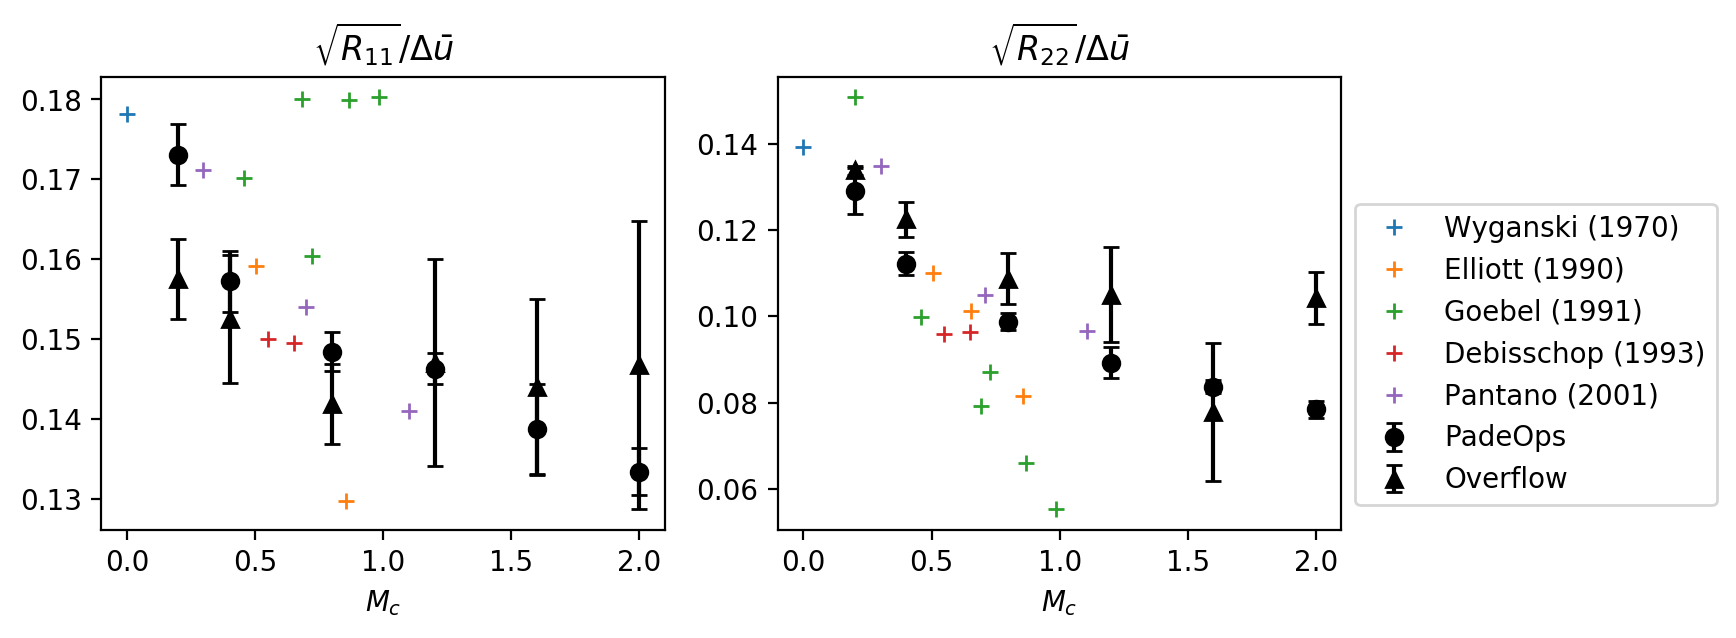

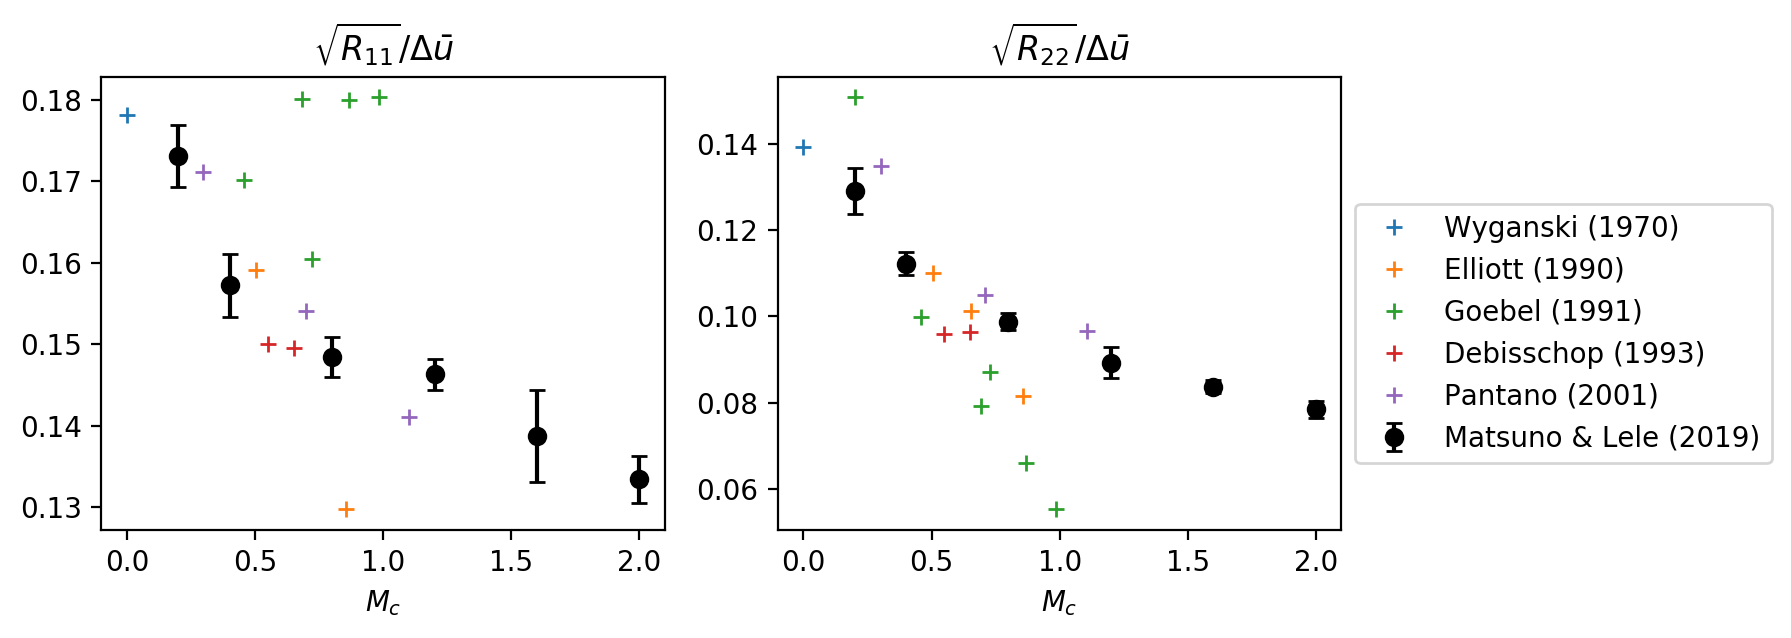

In [36]:
# Compare to lit

def plot_lit():
    ax[0].plot(0,0.17814902655789827,'+',label='Wyganski (1970)')
    dat = {
        0.503867705699914: 0.159159738330423,
        0.853478068232166: 0.12979019520967444,}
    ax[0].plot(dat.keys(),dat.values(),'+',label='Elliot (1990)')

    dat = {
        0.4560009382574475: 0.17012275534937055,
        0.6827152128020016: 0.1800078188120618,
        0.7235685058250151: 0.16039302561964083,
        0.8646355130443847: 0.1798973129349214,
        0.9847793791863223: 0.18027991347181316}
    ax[0].plot(dat.keys(),dat.values(),'+',label='Goebel (1991)')

    dat = {
        0.5483332898954886: 0.15002111079256691,
        0.6512992259376061: 0.1495029841799369}
    ax[0].plot(dat.keys(),dat.values(),'+',label='Debisschop (1993)')

    dat = {
        0.2981234851051629: 0.17112981834293306,
        0.6994318329901744: 0.15402955510959365,
        1.1008105501837422: 0.14102947692147305,}
    ax[0].plot(dat.keys(),dat.values(),'+',label='Pantano (2001)')

    # R22
    ax[1].plot(0,0.1392438644751397,'+',label='Wyganski (1970)')

    dat = {
        0.5051198715626866: 0.11012520680169548,
        0.6539803819835341: 0.10130003622088865,
        0.85894900686239: 0.08140497890377965,}
    ax[1].plot(dat.keys(),dat.values(),'+',label='Elliott (1990)')

    dat = {
        0.20115808949496328: 0.15083356991120983,
        0.4585931611046392: 0.0999118951356325,
        0.6933485722117257: 0.07913872600366123,
        0.7265934743663793: 0.0871308161447269,
        0.8686258577987489: 0.06588677545985841,
        0.987655529559182: 0.05527894979001671,}
    ax[1].plot(dat.keys(),dat.values(),'+',label='Goebel (1991)')

    dat = {
        0.5483332898954886: 0.0959481551820344,
        0.6512992259376061: 0.09642294250668124}
    ax[1].plot(dat.keys(),dat.values(),'+',label='Debisschop (1993)')

    dat = {
        0.3035432839619778: 0.1348993157188867,
        0.7070195103327426: 0.10486338851308354,
        1.1075442237471975: 0.09655607874616984,}
    ax[1].plot(dat.keys(),dat.values(),'+',label='Pantano (2001)')


def make_nice():
    ax[0].set_title(r'$\sqrt{R_{11}}/\Delta \bar{u}$')
    ax[1].set_title(r'$\sqrt{R_{22}}/\Delta \bar{u}$')
    ax[0].set_xlabel('$M_c$')
    ax[1].set_xlabel('$M_c$')
    ax[1].legend(bbox_to_anchor=(1, 0.75))
    
fig,ax = plt.subplots(1,2,figsize=(8,3),dpi=200)
plot_lit()
for i in range(2):
    ax[i].errorbar(Rij[i].keys(),[x[0] for x in Rij[i].values()],
        yerr=[x[1] for x in Rij[i].values()],fmt='ko',capsize=3,label='PadeOps')
    ax[i].errorbar(Rij_ovf[i].keys(),[x[0] for x in Rij_ovf[i].values()],
        yerr=[x[1] for x in Rij_ovf[i].values()],fmt='^',color='k',capsize=3,label='Overflow')
make_nice()
plt.savefig('/home/kmatsuno/Ovf_compare/Rij_peaks_lit.png',dpi=DPI, bbox_inches='tight')

fig,ax = plt.subplots(1,2,figsize=(8,3),dpi=200)
plot_lit()
for i in range(2):
    ax[i].errorbar(Rij[i].keys(),[x[0] for x in Rij[i].values()],
        yerr=[x[1] for x in Rij[i].values()],fmt='ko',capsize=3,label='Matsuno & Lele (2019)')
make_nice()
plt.savefig('/home/kmatsuno/ShearLayer_img/Rij_peaks_lit.png',dpi=DPI, bbox_inches='tight')
